#  Análise de Sentimento com FinBERT-PT-BR

Este notebook implementa a análise de sentimento das notícias do InfoMoney usando o modelo **FinBERT-PT-BR** (state-of-the-art para finanças em português).

## Objetivos:
1.  Carregar e testar o modelo FinBERT-PT-BR
2.  Processar todas as 11.504 notícias
3.  Realizar análise exploratória dos sentimentos
4.  Agregar sentimentos por data

---

## 1. Setup & Importações

In [1]:
import sys
import os

# Fix para erro de Unicode no Windows
os.environ["PYTHONUTF8"] = "1"

# Adiciona o diretório raiz ao path para importar módulos
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Módulos do projeto
from src.sentiment.sentiment_analyzer import (
    setup_sentiment_model,
    predict_sentiment,
    predict_batch,
    analyze_news_file
)
from src.sentiment.daily_aggregation import aggregate_daily_sentiment

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(" Importações concluídas!")

 Importações concluídas!


## 2. Verificação de GPU

In [2]:
import torch

print(f"Versão do PyTorch: {torch.__version__}")
print(f"CUDA Disponível: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Detectada: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memória Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("️GPU não detectada. O processamento será em CPU (mais lento).")

Versão do PyTorch: 2.5.1+cu121
CUDA Disponível: True
GPU Detectada: NVIDIA GeForce GTX 1650
CUDA Version: 12.1
Memória Total: 4.29 GB


## 2.1 Validação Manual (TCC Requirement)
Comparação das predições do modelo com labels manuais para validar a acurácia.

Carregado dataset de validação com 155 amostras.
🔄 Loading model: lucas-leme/FinBERT-PT-BR...
💻 Device: cuda
   GPU: NVIDIA GeForce GTX 1650
   CUDA Version: 12.1


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: lucas-leme/FinBERT-PT-BR
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded successfully!
   Model parameters: 108,925,443
Realizando predições no dataset de validação...


Analyzing sentiment: 100%|██████████| 5/5 [00:00<00:00,  6.68batch/s]



RELATÓRIO DE VALIDAÇÃO MANUAL
Amostras usadas: 155

--- Métricas Gerais ---
Acurácia: 0.7677

--- Classification Report ---
              precision    recall  f1-score   support

    negative       0.68      0.93      0.79        54
     neutral       0.80      0.63      0.70        51
    positive       0.88      0.74      0.80        50

    accuracy                           0.77       155
   macro avg       0.79      0.76      0.77       155
weighted avg       0.79      0.77      0.77       155


--- Matriz de Confusão ---


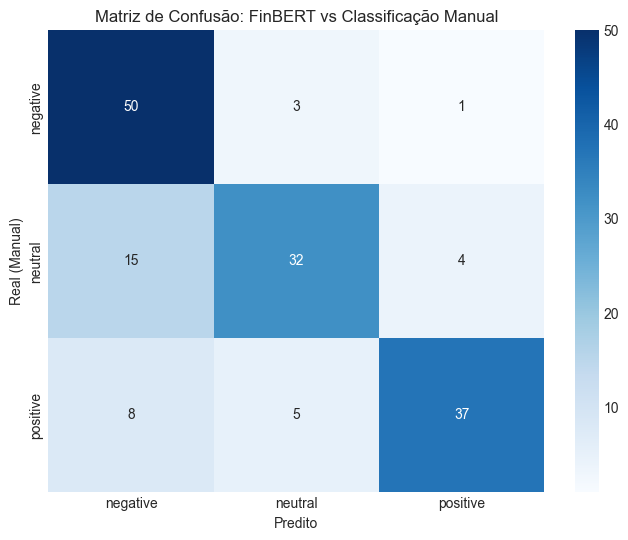


Resultados detalhados salvos em: ../src/dataset/sentiment/news_with_sentiment_manual_labeling_results.csv


In [3]:
# --- VALIDAÇÃO MANUAL DO MODELO ---

# Carregar dataset de validação manual
manual_labels_path = r'../src/dataset/sentiment/news_with_sentiment_manual_labeling.csv'
df_manual = pd.read_csv(manual_labels_path)

print(f"Carregado dataset de validação com {len(df_manual)} amostras.")

# Converter sentimento manual para o formato do modelo se necessário (-1, 0, 1) -> (negative, neutral, positive)
# Assumindo que o arquivo tem coluna 'sentiment' com valores numéricos ou strings mapeáveis
label_map = {
    -1: 'negative',
    0: 'neutral',
    1: 'positive',
    '-1': 'negative',
    '0': 'neutral',
    '1': 'positive'
}

if 'sentiment' in df_manual.columns:
    # Garantir que temos labels comparáveis
    df_manual['manual_label'] = df_manual['sentiment'].map(label_map)
    
    # Carregar modelo (garantindo que está carregado)
    model, tokenizer, device = setup_sentiment_model()
    
    # Fazer predições no dataset de validação
    print("Realizando predições no dataset de validação...")
    # predict_batch returns a DataFrame with columns: prob_neg, prob_neu, prob_pos, sentiment_score
    df_results = predict_batch(df_manual['title'].tolist(), model, tokenizer, device)
    
    # Extract predicted label from probabilities
    # Map columns to labels: prob_neg -> negative, prob_neu -> neutral, prob_pos -> positive
    prob_cols = ['prob_neg', 'prob_neu', 'prob_pos']
    col_to_label = {'prob_neg': 'negative', 'prob_neu': 'neutral', 'prob_pos': 'positive'}
    
    # Find the column with max probability for each row and map to label
    df_manual['predicted_label'] = df_results[prob_cols].idxmax(axis=1).map(col_to_label)
    df_manual['predicted_score'] = df_results['sentiment_score']
    
    # Calcular métricas
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    # Remover NaN se houver (caso algum label manual não tenha sido mapeado)
    df_valid = df_manual.dropna(subset=['manual_label', 'predicted_label'])
    
    print("\n" + "="*50)
    print("RELATÓRIO DE VALIDAÇÃO MANUAL")
    print("="*50)
    print(f"Amostras usadas: {len(df_valid)}")
    
    print("\n--- Métricas Gerais ---")
    acc = accuracy_score(df_valid['manual_label'], df_valid['predicted_label'])
    print(f"Acurácia: {acc:.4f}")
    
    print("\n--- Classification Report ---")
    print(classification_report(df_valid['manual_label'], df_valid['predicted_label']))
    
    print("\n--- Matriz de Confusão ---")
    labels = ['negative', 'neutral', 'positive']
    cm = confusion_matrix(df_valid['manual_label'], df_valid['predicted_label'], labels=labels)
    
    # Plotar matriz
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predito')
    plt.ylabel('Real (Manual)')
    plt.title('Matriz de Confusão: FinBERT vs Classificação Manual')
    plt.show()
    
    # Salvar resultados da validação
    output_val_path = manual_labels_path.replace('.csv', '_results.csv')
    df_manual.to_csv(output_val_path, index=False)
    print(f"\nResultados detalhados salvos em: {output_val_path}")
else:
    print("ERRO: Coluna 'sentiment' não encontrada no arquivo de validação manual.")

## 4. Processamento do Dataset Completo

Vamos Carregar o modelo:


In [4]:
# Carregar modelo
print("Carregando modelo FinBERT-PT-BR...\n")
tokenizer, model, device = setup_sentiment_model()

print(f"\n Modelo pronto para uso!")

Carregando modelo FinBERT-PT-BR...

🔄 Loading model: lucas-leme/FinBERT-PT-BR...
💻 Device: cuda
   GPU: NVIDIA GeForce GTX 1650
   CUDA Version: 12.1


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: lucas-leme/FinBERT-PT-BR
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded successfully!
   Model parameters: 108,925,443

 Modelo pronto para uso!


Agora vamos processar as notícias do InfoMoney.

In [5]:
END_DATE = datetime(2025, 12, 31)
# Caminhos dos arquivos
input_path = '../src/dataset/scraper/consolidated_news_20260209.csv'
output_path = '../src/dataset/sentiment/news_with_sentiment.csv'

print(f" Arquivo de entrada: {input_path}")
print(f" Arquivo de saída: {output_path}")
print("\n Processamento iniciado... (isso pode levar alguns minutos)\n")


 Arquivo de entrada: ../src/dataset/scraper/consolidated_news_20260209.csv
 Arquivo de saída: ../src/dataset/sentiment/news_with_sentiment.csv

 Processamento iniciado... (isso pode levar alguns minutos)



In [6]:
df_input = pd.read_csv(input_path)
df_input['date'] = pd.to_datetime(df_input['date'])
df_input = df_input[df_input['date'] <= END_DATE]
input_path_filtered = input_path.replace('.csv', '_filtered.csv')
df_input.to_csv(input_path_filtered, index=False)

# Processar todas as notícias
# NOTA: Com GPU, deve levar ~5-10 minutos. Com CPU, ~20-30 minutos.

df_with_sentiment = analyze_news_file(
    input_csv_path=input_path_filtered,
    output_csv_path=output_path,
    text_column='title',
    batch_size=32  # Ajuste para 64 ou 128 se tiver GPU potente
)

print("\n Processamento concluído!")



SENTIMENT ANALYSIS PIPELINE

📂 Loading data from: ../src/dataset/scraper/consolidated_news_20260209_filtered.csv
   Total news: 5,909
🔄 Loading model: lucas-leme/FinBERT-PT-BR...
💻 Device: cuda
   GPU: NVIDIA GeForce GTX 1650
   CUDA Version: 12.1


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: lucas-leme/FinBERT-PT-BR
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded successfully!
   Model parameters: 108,925,443

🤖 Processing 5,909 texts...
   Batch size: 32
   Device: cuda



Analyzing sentiment: 100%|██████████| 185/185 [00:24<00:00,  7.60batch/s]


💾 Saving results to: ../src/dataset/sentiment/news_with_sentiment.csv
✅ Analysis complete!


 Processamento concluído!


## 5. Análise Exploratória dos Resultados

In [7]:
# Carregar resultados (caso o notebook seja reiniciado)
df_with_sentiment = pd.read_csv(output_path)
df_with_sentiment['date'] = pd.to_datetime(df_with_sentiment['date'])

print(f"Total de notícias processadas: {len(df_with_sentiment):,}")
print(f"Período: {df_with_sentiment['date'].min()} até {df_with_sentiment['date'].max()}")
print(f"\nPrimeiras linhas:")
df_with_sentiment.head()

Total de notícias processadas: 5,909
Período: 2025-01-01 08:22:14 até 2025-12-30 19:14:13

Primeiras linhas:


,date,title,link,prob_neg,prob_neu,prob_pos,sentiment_score
0,2025-12-30 19:14:13,"Ouro fecha ano com alta de 65,24%; Ibovespa é ...",https://www.infomoney.com.br/mercados/ouro-fec...,0.035907,0.038484,0.925609,0.889701
1,2025-12-30 19:03:37,O que fez o Ibovespa subir mais de 30% em reai...,https://www.infomoney.com.br/mercados/ibovespa...,0.107035,0.077990,0.814976,0.707941
2,2025-12-30 18:53:07,Ibovespa encerra ano em alta e sobe 34% em 202...,https://www.infomoney.com.br/mercados/ibovespa...,0.044180,0.035900,0.919920,0.875741
3,2025-12-30 18:39:39,4 ações saltam mais de 100% em 2025: confira o...,https://www.infomoney.com.br/mercados/4-acoes-...,0.033597,0.049536,0.916867,0.883270
4,2025-12-30 18:39:32,5 ações caem mais de 30% em 2025; confira os d...,https://www.infomoney.com.br/mercados/5-acoes-...,0.937475,0.031178,0.031346,-0.906129


### 5.1 Estatísticas Descritivas

In [8]:
print("="*60)
print("ESTATÍSTICAS DE SENTIMENTO")
print("="*60)

print("\nPontuação de Sentimento:")
print(df_with_sentiment['sentiment_score'].describe())

print("\nProbabilidades:")
print(df_with_sentiment[['prob_neg', 'prob_neu', 'prob_pos']].describe())

ESTATÍSTICAS DE SENTIMENTO

Pontuação de Sentimento:
count    5909.000000
mean       -0.219391
std         0.587060
min        -0.915449
25%        -0.855751
50%        -0.117729
75%         0.130368
max         0.914870
Name: sentiment_score, dtype: float64

Probabilidades:
          prob_neg     prob_neu     prob_pos
count  5909.000000  5909.000000  5909.000000
mean      0.446110     0.327171     0.226719
std       0.376273     0.307753     0.279454
min       0.023834     0.026746     0.023616
25%       0.082206     0.051326     0.040120
50%       0.265004     0.168448     0.090275
75%       0.896513     0.663762     0.276294
max       0.942105     0.863434     0.943892


### 5.2 Distribuição de Sentimentos

In [9]:
# Classificar notícias
df_with_sentiment['sentiment_class'] = pd.cut(
    df_with_sentiment['sentiment_score'],
    bins=[-np.inf, -0.2, 0.2, np.inf],
    labels=['Negativo', 'Neutro', 'Positivo']
)

# Contagem
sentiment_counts = df_with_sentiment['sentiment_class'].value_counts()
print("\nDistribuição de Sentimentos:")
print(sentiment_counts)
print(f"\nPercentuais:")
print(sentiment_counts / len(df_with_sentiment) * 100)


Distribuição de Sentimentos:
sentiment_class
Negativo    2752
Neutro      1834
Positivo    1323
Name: count, dtype: int64

Percentuais:
sentiment_class
Negativo    46.573024
Neutro      31.037401
Positivo    22.389575
Name: count, dtype: float64


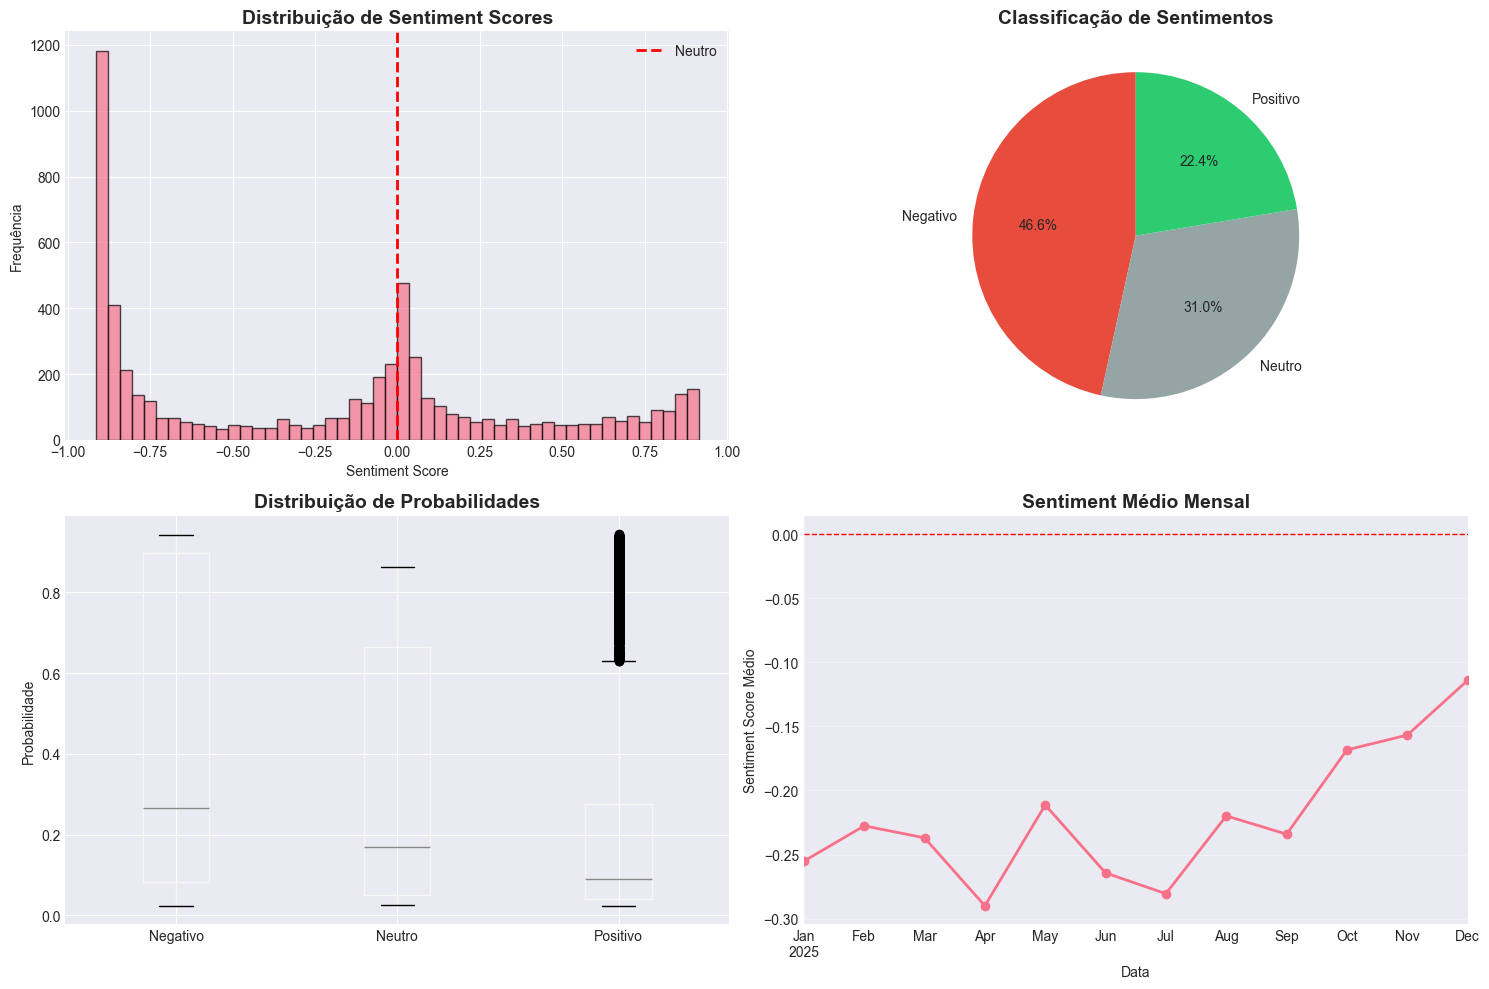

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histograma de scores
axes[0, 0].hist(df_with_sentiment['sentiment_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutro')
axes[0, 0].set_title('Distribuição de Sentiment Scores', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()

# 2. Pizza de classificação
colors_pie = ['#e74c3c', '#95a5a6', '#2ecc71']
sentiment_counts.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%', colors=colors_pie, startangle=90)
axes[0, 1].set_title('Classificação de Sentimentos', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('')

# 3. Boxplot de probabilidades
df_with_sentiment[['prob_neg', 'prob_neu', 'prob_pos']].boxplot(ax=axes[1, 0])
axes[1, 0].set_title('Distribuição de Probabilidades', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Probabilidade')
axes[1, 0].set_xticklabels(['Negativo', 'Neutro', 'Positivo'])

# 4. Evolução temporal (amostra mensal)
df_monthly = df_with_sentiment.set_index('date').resample('ME')['sentiment_score'].mean()
df_monthly.plot(ax=axes[1, 1], marker='o', linewidth=2)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_title('Sentiment Médio Mensal', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Data')
axes[1, 1].set_ylabel('Sentiment Score Médio')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Top Notícias Mais Positivas e Negativas

In [11]:
print("="*80)
print("TOP 10 NOTÍCIAS MAIS POSITIVAS")
print("="*80 + "\n")

top_positive = df_with_sentiment.nlargest(10, 'sentiment_score')[['date', 'title', 'sentiment_score']]
for idx, row in top_positive.iterrows():
    print(f"Score: {row['sentiment_score']:+.3f} | {row['date'].date()}")
    print(f"  '{row['title']}'")
    print()

print("\n" + "="*80)
print("TOP 10 NOTÍCIAS MAIS NEGATIVAS")
print("="*80 + "\n")

top_negative = df_with_sentiment.nsmallest(10, 'sentiment_score')[['date', 'title', 'sentiment_score']]
for idx, row in top_negative.iterrows():
    print(f"Score: {row['sentiment_score']:+.3f} | {row['date'].date()}")
    print(f"  '{row['title']}'")
    print()

TOP 10 NOTÍCIAS MAIS POSITIVAS

Score: +0.915 | 2025-06-30
  'Ibovespa tem novo ganho mensal e sobe 15,4% em 2025, no melhor 1º semestre desde 2016'

Score: +0.914 | 2025-04-10
  'Morgan eleva exposição em ações do Brasil na América Latina; veja carteira de ativos'

Score: +0.913 | 2025-02-20
  'B3 (B3SA3) tem lucro líquido recorrente de R$ 1,2 bilhões, com alta anual de 13,6%'

Score: +0.913 | 2025-02-06
  'Ibovespa fecha em alta, acima dos 126 mil pontos, puxado por Vale e com Itaú em foco'

Score: +0.913 | 2025-09-19
  'Ibovespa fecha em máxima histórica, aos 145.865 pontos, e avança 2,53% na semana'

Score: +0.912 | 2025-03-19
  'Ibovespa tem maior série de ganhos desde agosto de 2024 e agora mira 133 mil pontos'

Score: +0.912 | 2025-11-06
  'Axia tem combinação de resultado robusto e dividendo de R$ 4,3 bilhões; ações sobem'

Score: +0.911 | 2025-05-02
  'Ibovespa fecha estável e assegura ganho semanal; Prio salta 8%'

Score: +0.910 | 2025-12-22
  'Marcopolo (POMO4) fecha com alt

## 6. Agregação Diária

Agora vamos agrupar os sentimentos por data para criar a série temporal que será correlacionada com os retornos do BOVA11.

In [12]:
# Agregar por data
daily_sentiment = aggregate_daily_sentiment(df_with_sentiment)

print(f"Total de dias com notícias: {len(daily_sentiment)}")
print(f"Período: {daily_sentiment['date'].min().date()} até {daily_sentiment['date'].max().date()}")
print(f"\nPrimeiras linhas:")
daily_sentiment.head(10)

Aplicando ajuste de datas (After-Market e Fim de Semana)...
Total de dias com notícias: 261
Período: 2025-01-01 até 2025-12-31

Primeiras linhas:


,date,sentiment_mean,sentiment_std,sentiment_min,sentiment_max,news_count,prob_neg_mean,prob_neu_mean,prob_pos_mean,count_negative,count_neutral,count_positive,sentiment_ma3,sentiment_momentum,sentiment_range
0,2025-01-01,-0.337441,0.464418,-0.849254,0.057098,3,0.412674,0.512094,0.075233,2,1,0,-0.337441,0.000000,0.906353
1,2025-01-02,-0.178189,0.643737,-0.904446,0.900968,13,0.419722,0.338746,0.241533,5,5,3,-0.257815,0.079626,1.805415
2,2025-01-03,-0.348476,0.612994,-0.911940,0.830880,10,0.507266,0.333944,0.158790,5,4,1,-0.288035,-0.060441,1.742820
3,2025-01-06,-0.162155,0.581156,-0.910699,0.843568,15,0.411463,0.339228,0.249308,6,5,4,-0.229607,0.067452,1.754266
4,2025-01-07,-0.070416,0.540111,-0.898225,0.847903,15,0.342596,0.385224,0.272180,4,8,3,-0.193682,0.123266,1.746127
5,2025-01-08,-0.251569,0.682087,-0.906339,0.891771,12,0.508863,0.233843,0.257294,6,3,3,-0.161380,-0.090189,1.798110
6,2025-01-09,-0.410477,0.410457,-0.902100,0.082876,13,0.504306,0.401865,0.093829,8,5,0,-0.244154,-0.166323,0.984975
7,2025-01-10,-0.278658,0.625737,-0.905366,0.862249,19,0.490469,0.297720,0.211811,9,6,4,-0.313568,0.034910,1.767615
8,2025-01-13,-0.402869,0.493412,-0.902736,0.551764,27,0.529530,0.343810,0.126660,15,9,3,-0.364001,-0.038868,1.454500
9,2025-01-14,-0.210823,0.559160,-0.907140,0.857018,20,0.415727,0.379369,0.204904,7,10,3,-0.297450,0.086627,1.764158


### 6.1 Estatísticas Diárias

In [13]:
print("="*60)
print("ESTATÍSTICAS DIÁRIAS")
print("="*60 + "\n")

print("Notícias por dia:")
print(daily_sentiment['news_count'].describe())

print("\nSentiment médio diário:")
print(daily_sentiment['sentiment_mean'].describe())

print("\nMomentum de sentimento:")
print(daily_sentiment['sentiment_momentum'].describe())

ESTATÍSTICAS DIÁRIAS

Notícias por dia:
count    261.000000
mean      22.639847
std        7.206340
min        2.000000
25%       18.000000
50%       22.000000
75%       28.000000
max       45.000000
Name: news_count, dtype: float64

Sentiment médio diário:
count    261.000000
mean      -0.223093
std        0.164388
min       -0.793069
25%       -0.326843
50%       -0.229620
75%       -0.137601
max        0.418581
Name: sentiment_mean, dtype: float64

Momentum de sentimento:
count    261.000000
mean       0.002120
std        0.118341
min       -0.323254
25%       -0.072833
50%       -0.001428
75%        0.072751
max        0.441873
Name: sentiment_momentum, dtype: float64


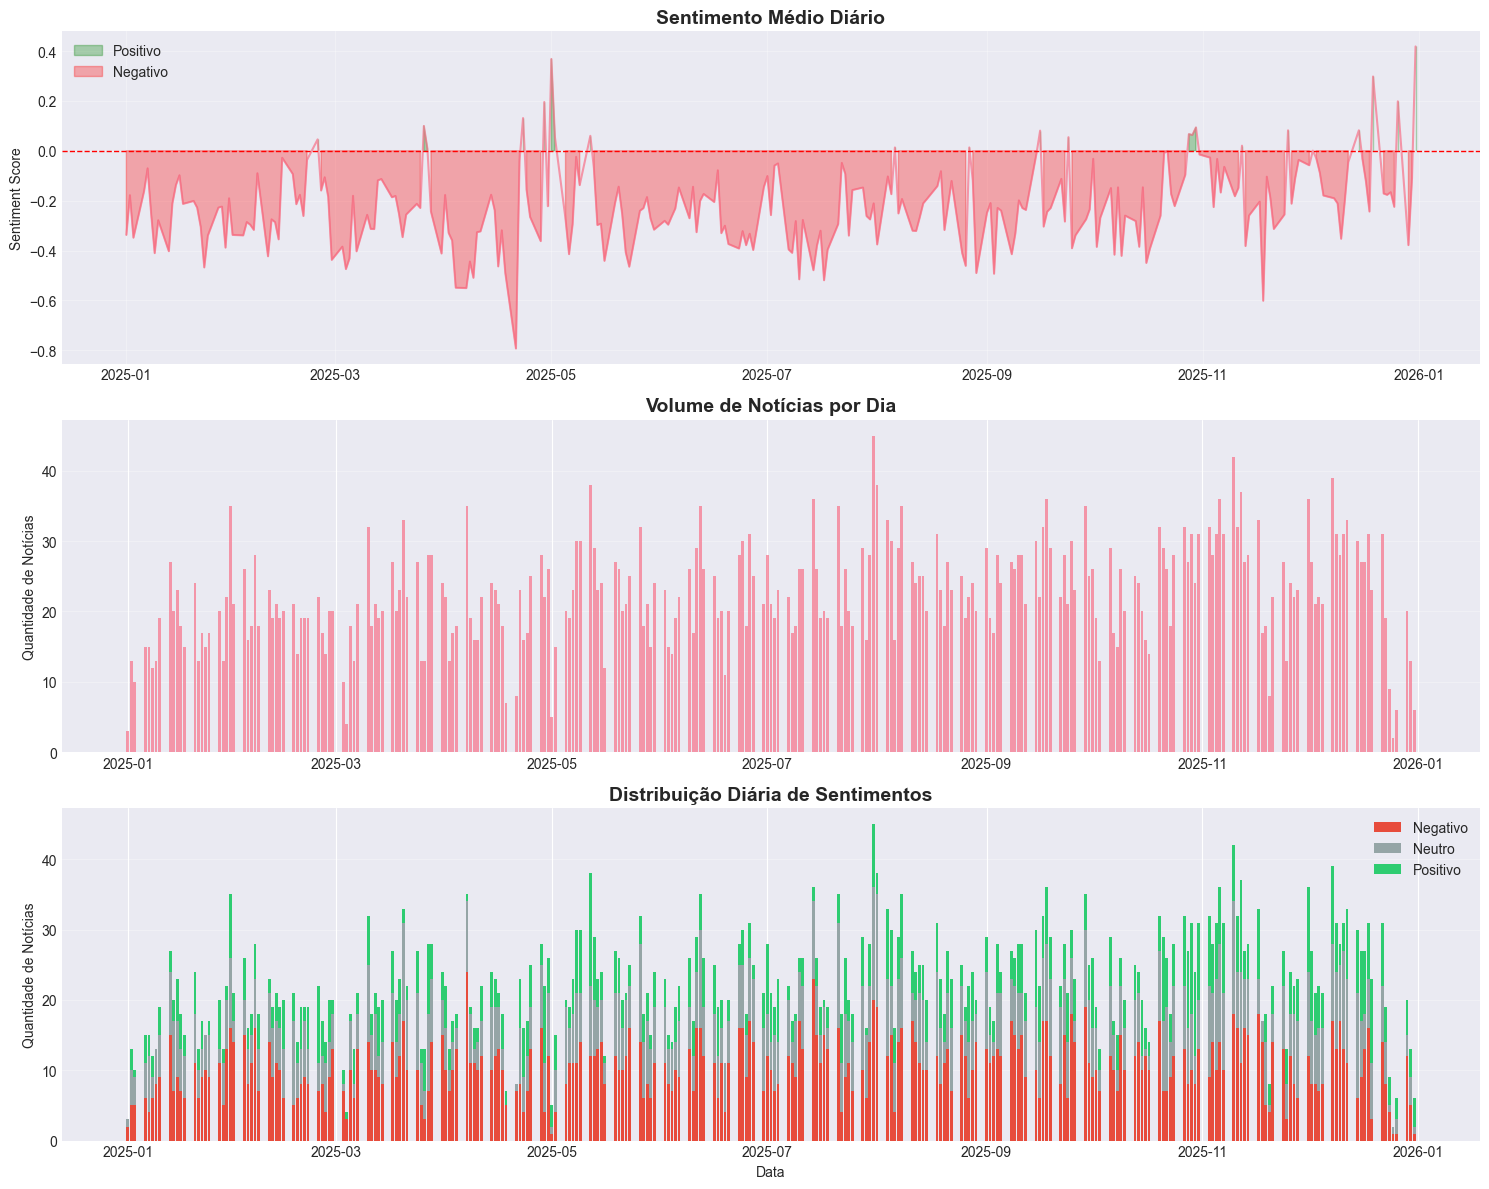

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Sentimento médio diário
axes[0].plot(daily_sentiment['date'], daily_sentiment['sentiment_mean'], linewidth=1.5, alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].fill_between(
    daily_sentiment['date'],
    daily_sentiment['sentiment_mean'],
    0,
    where=(daily_sentiment['sentiment_mean'] > 0),
    alpha=0.3,
    color='green',
    label='Positivo'
)
axes[0].fill_between(
    daily_sentiment['date'],
    daily_sentiment['sentiment_mean'],
    0,
    where=(daily_sentiment['sentiment_mean'] <= 0),
    alpha=0.3,
    color='red',
    label='Negativo'
)
axes[0].set_title('Sentimento Médio Diário', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sentiment Score')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Volume de notícias
axes[1].bar(daily_sentiment['date'], daily_sentiment['news_count'], alpha=0.7)
axes[1].set_title('Volume de Notícias por Dia', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Quantidade de Notícias')
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Distribuição de sentimentos (stacked)
axes[2].bar(daily_sentiment['date'], daily_sentiment['count_negative'], label='Negativo', color='#e74c3c')
axes[2].bar(daily_sentiment['date'], daily_sentiment['count_neutral'], 
            bottom=daily_sentiment['count_negative'], label='Neutro', color='#95a5a6')
axes[2].bar(daily_sentiment['date'], daily_sentiment['count_positive'],
            bottom=daily_sentiment['count_negative'] + daily_sentiment['count_neutral'],
            label='Positivo', color='#2ecc71')
axes[2].set_title('Distribuição Diária de Sentimentos', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Quantidade de Notícias')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 6.2 Salvar Dados Agregados

In [15]:
# Salvar agregação diária
daily_output_path = '../src/dataset/sentiment/daily_sentiment.csv'
daily_sentiment.to_csv(daily_output_path, index=False)

print(f" Dados diários salvos em: {daily_output_path}")
print(f"   Total de dias: {len(daily_sentiment)}")
print(f"   Colunas: {list(daily_sentiment.columns)}")

 Dados diários salvos em: ../src/dataset/sentiment/daily_sentiment.csv
   Total de dias: 261
   Colunas: ['date', 'sentiment_mean', 'sentiment_std', 'sentiment_min', 'sentiment_max', 'news_count', 'prob_neg_mean', 'prob_neu_mean', 'prob_pos_mean', 'count_negative', 'count_neutral', 'count_positive', 'sentiment_ma3', 'sentiment_momentum', 'sentiment_range']


## 7. Resumo Final

In [16]:
print("="*80)
print("RESUMO DA ANÁLISE DE SENTIMENTO")
print("="*80)

print(f"\n Dados Processados:")
print(f"   - Total de notícias: {len(df_with_sentiment):,}")
print(f"   - Período: {df_with_sentiment['date'].min().date()} até {df_with_sentiment['date'].max().date()}")
print(f"   - Dias com notícias: {len(daily_sentiment)}")

print(f"\n Estatísticas Gerais:")
print(f"   - Sentimento médio geral: {df_with_sentiment['sentiment_score'].mean():+.4f}")
print(f"   - Desvio padrão: {df_with_sentiment['sentiment_score'].std():.4f}")
print(f"   - Notícias positivas: {sentiment_counts['Positivo']:,} ({sentiment_counts['Positivo']/len(df_with_sentiment)*100:.1f}%)")
print(f"   - Notícias neutras: {sentiment_counts['Neutro']:,} ({sentiment_counts['Neutro']/len(df_with_sentiment)*100:.1f}%)")
print(f"   - Notícias negativas: {sentiment_counts['Negativo']:,} ({sentiment_counts['Negativo']/len(df_with_sentiment)*100:.1f}%)")

print(f"\n Arquivos Gerados:")
print(f"   1. {output_path}")
print(f"      Todas as notícias com sentiment score")
print(f"   2. {daily_output_path}")
print(f"      Agregação diária de sentimento")

print(f"\n Próximo passo: Executar notebook 03_sentiment_market_merge.ipynb")
print(f"   para fazer o merge com os dados do BOVA11!")
print("\n" + "="*80)

RESUMO DA ANÁLISE DE SENTIMENTO

 Dados Processados:
   - Total de notícias: 5,909
   - Período: 2025-01-01 até 2025-12-30
   - Dias com notícias: 261

 Estatísticas Gerais:
   - Sentimento médio geral: -0.2194
   - Desvio padrão: 0.5871
   - Notícias positivas: 1,323 (22.4%)
   - Notícias neutras: 1,834 (31.0%)
   - Notícias negativas: 2,752 (46.6%)

 Arquivos Gerados:
   1. ../src/dataset/sentiment/news_with_sentiment.csv
      Todas as notícias com sentiment score
   2. ../src/dataset/sentiment/daily_sentiment.csv
      Agregação diária de sentimento

 Próximo passo: Executar notebook 03_sentiment_market_merge.ipynb
   para fazer o merge com os dados do BOVA11!

